# GFA Zero Calibration

GFA calibrations should normally be updated in the following sequence: zeros, flats, darks.

This notebook should be run using a DESI kernel, e.g. `DESI master`.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import sys
import json
import collections
from pathlib import Path

In [4]:
import scipy.interpolate
import scipy.stats

In [5]:
import fitsio

Install / upgrade the `desietcimg` package:

In [6]:
try:
    import desietcimg
    print('desietcimg already installed')
except ImportError:
    print('Installing desietcimg...')
    !{sys.executable} -m pip install --user git+https://github.com/dkirkby/desietcimg

desietcimg already installed


In [7]:
upgrade = False
if upgrade:
    print('Upgrading desietcimg...')
    !{sys.executable} -m pip install --upgrade --user git+https://github.com/dkirkby/desietcimg

In [8]:
import desietcimg.util
import desietcimg.plot
import desietcimg.gfa

NERSC configuration:

In [9]:
assert os.getenv('NERSC_HOST', False)

In [10]:
ROOT = Path('/project/projectdirs/desi/spectro/data/')
assert ROOT.exists()

Initial GFA calibration:

In [11]:
CALIB = Path('/global/cscratch1/sd/dkirkby/GFA_calib.fits')
assert CALIB.exists()

Directory for saving plots:

In [12]:
plotdir = Path('zerocal')
plotdir.mkdir(exist_ok=True)

## Process Zero Sequences

Use a sequence of 200 zeros from [20191027](http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2019-10-27/nightsum.html).

**Since this data has not yet been staged to its final location, we fetch it from the `lost+found` directory** (by overriding the definition of `ROOT` above):

In [13]:
ROOT = Path('/global/project/projectdirs/desi/spectro/staging/lost+found/')

In [14]:
files = desietcimg.util.find_files(ROOT / '20191027' / '{N}/gfa-{N}.fits.fz', min=21968, max=22167)

Build master zero images:

In [15]:
def build_master_zero():
    master_zero = {}
    GFA = desietcimg.gfa.GFACamera(calib_name=str(CALIB))
    for k, gfa in enumerate(GFA.gfa_names):
        raw, meta = desietcimg.util.load_raw(files, 'EXPTIME', hdu=gfa)
        assert np.all(np.array(meta['EXPTIME']) == 0)
        GFA.setraw(raw, name=gfa, subtract_master_zero=False, apply_gain=False)
        master_zero[gfa] = np.median(GFA.data, axis=0)
    return master_zero

In [16]:
%time master_zero = build_master_zero()

CPU times: user 2min 17s, sys: 16.5 s, total: 2min 34s
Wall time: 5min 37s


Estimate the readnoise in ADU for each amplifier, using the new master zero:

In [17]:
desietcimg.gfa.GFACamera.master_zero = master_zero

In [23]:
def get_readnoise(hrange=70, hbins=141, nsig=6, save=None):
    GFA = desietcimg.gfa.GFACamera(calib_name=str(CALIB))
    fig, axes = plt.subplots(5, 2, sharex=True, figsize=(18, 11))
    bins = np.linspace(-hrange, +hrange, hbins)
    noise = {}
    for k, gfa in enumerate(GFA.gfa_names):
        GFA.name = gfa
        ax = axes[k // 2, k % 2]
        raw, meta = desietcimg.util.load_raw(files, 'EXPTIME', hdu=gfa)
        assert np.all(np.array(meta['EXPTIME']) == 0)
        GFA.setraw(raw, name=gfa, subtract_master_zero=True, apply_gain=False)
        noise[gfa] = {}
        for j, amp in enumerate(GFA.amp_names):
            # Extract data for this quadrant.
            qdata = GFA.data[GFA.quad[amp]]
            X = qdata.reshape(-1)
            # Clip for std dev calculation.
            Xclipped, lo, hi = scipy.stats.sigmaclip(X, low=nsig, high=nsig)
            noise[gfa][amp] = np.std(Xclipped)
            label = f'{amp} {noise[gfa][amp]:.2f}'
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j]
            ax.hist(X, bins=bins, label=label, color=c, histtype='step')
            for x in lo, hi:
                ax.axvline(x, ls='-', c=c, alpha=0.5)
        ax.set_yscale('log')
        ax.set_yticks([])
        if k in (8, 9):
            ax.set_xlabel('Zero Residual [ADU]')
            ax.set_xlim(bins[0], bins[-1])
        ax.legend(ncol=2, title=f'{gfa}', loc='upper left')
    plt.subplots_adjust(left=0.03, right=0.99, bottom=0.04, top=0.99, wspace=0.07, hspace=0.04)
    if save:
        plt.savefig(save)
    return noise

CPU times: user 6min 2s, sys: 38.3 s, total: 6min 40s
Wall time: 9min 51s


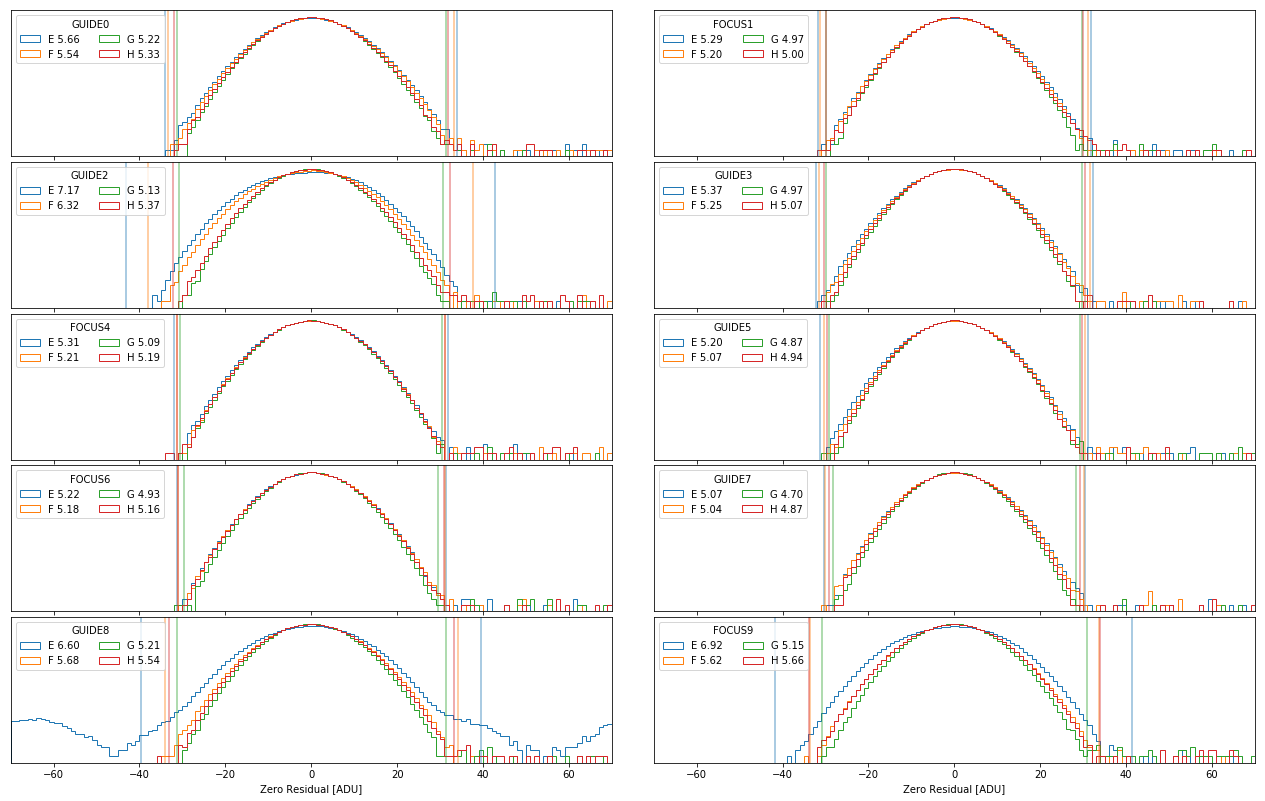

In [24]:
%time readnoise = get_readnoise(save=str(plotdir / 'GFA_readnoise.png'))

In [25]:
repr(readnoise)

"{'GUIDE0': {'E': 5.660343, 'F': 5.543253, 'G': 5.21963, 'H': 5.327375}, 'FOCUS1': {'E': 5.2914505, 'F': 5.20432, 'G': 4.9670053, 'H': 5.0010734}, 'GUIDE2': {'E': 7.1716886, 'F': 6.315435, 'G': 5.1258264, 'H': 5.3712153}, 'GUIDE3': {'E': 5.3671136, 'F': 5.2473817, 'G': 4.9686685, 'H': 5.0736904}, 'FOCUS4': {'E': 5.310546, 'F': 5.2088857, 'G': 5.087248, 'H': 5.1949167}, 'GUIDE5': {'E': 5.1985097, 'F': 5.065055, 'G': 4.8730245, 'H': 4.94059}, 'FOCUS6': {'E': 5.2173424, 'F': 5.1802764, 'G': 4.9312873, 'H': 5.156993}, 'GUIDE7': {'E': 5.0734177, 'F': 5.0405536, 'G': 4.7034435, 'H': 4.8684793}, 'GUIDE8': {'E': 6.598423, 'F': 5.6812797, 'G': 5.214789, 'H': 5.5419116}, 'FOCUS9': {'E': 6.9221535, 'F': 5.618702, 'G': 5.153582, 'H': 5.6583614}}"

## Save Updated Calibrations

In [31]:
desietcimg.gfa.save_calib_data('GFA_calib_zero.fits', master_zero=master_zero, readnoise=readnoise)

Using default master_dark
Using default pixel_mask
Using default gain
Using default tempfit
Saved GFA calib data to GFA_calib_zero.fits.


Use this for subsequent flat and dark calibrations:

In [32]:
!cp GFA_calib_zero.fits {CALIB}

## Comparisons

Compare with the read noise values from the lab studies and Aaron Meisner's [independent analysis](https://desi.lbl.gov/trac/wiki/Commissioning/Planning/gfachar/bias_readnoise_20191027):

In [28]:
ameisner_rdnoise = {
    'GUIDE0': { 'E': 5.56, 'F': 5.46, 'G': 5.12, 'H': 5.24},
    'FOCUS1': { 'E': 5.21, 'F': 5.11, 'G': 4.88, 'H': 4.90},
    'GUIDE2': { 'E': 7.11, 'F': 6.23, 'G': 5.04, 'H': 5.29},
    'GUIDE3': { 'E': 5.28, 'F': 5.16, 'G': 4.89, 'H': 5.00},
    'FOCUS4': { 'E': 5.23, 'F': 5.12, 'G': 5.01, 'H': 5.11},
    'GUIDE5': { 'E': 5.11, 'F': 5.00, 'G': 4.80, 'H': 4.86},
    'FOCUS6': { 'E': 5.12, 'F': 5.09, 'G': 4.85, 'H': 5.07},
    'GUIDE7': { 'E': 5.00, 'F': 4.96, 'G': 4.63, 'H': 4.79},
    'GUIDE8': { 'E': 6.51, 'F': 5.58, 'G': 5.12, 'H': 5.47},
    'FOCUS9': { 'E': 6.85, 'F': 5.53, 'G': 5.07, 'H': 5.57},
}

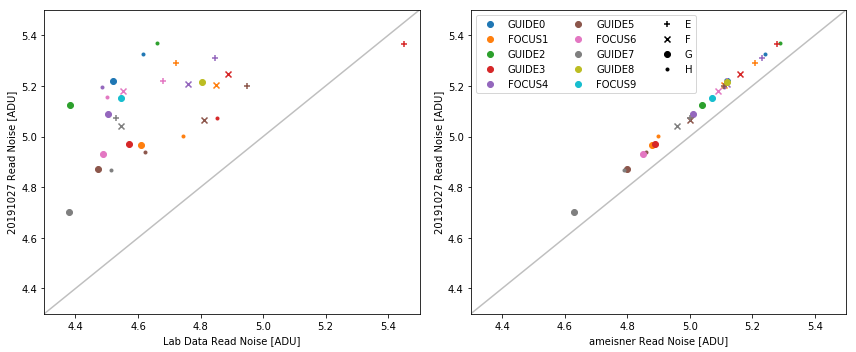

In [33]:
def compare_rdnoise(label='20191027', save=None):
    # Use the new calibrations written above.
    desietcimg.gfa.GFACamera.calib_data = None
    GFA = desietcimg.gfa.GFACamera(calib_name='GFA_calib_zero.fits')
    markers = '+xo.'
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    for k, gfa in enumerate(GFA.gfa_names):
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][k]
        ax[1].scatter([], [], marker='o', c=color, label=gfa)
        for j, amp in enumerate(desietcimg.gfa.GFACamera.amp_names):
            marker = markers[j]
            measured = GFA.calib_data[gfa][amp]['RDNOISE']
            # Lab results are given in elec so use lab gains to convert back to ADU
            lab = GFA.lab_data[gfa][amp]['RDNOISE'] / GFA.lab_data[gfa][amp]['GAIN']
            ax[0].scatter(lab, measured, marker=marker, c=color)
            ax[1].scatter(ameisner_rdnoise[gfa][amp], measured, marker=marker, c=color)
    for j, amp in enumerate(GFA.amp_names):
        ax[1].scatter([], [], marker=markers[j], c='k', label=amp)
    xylim = (4.3, 5.5)
    for axis in ax:
        axis.plot(xylim, xylim, 'k-', zorder=-10, alpha=0.25)
        axis.set_ylabel(f'{label} Read Noise [ADU]')
        axis.set_xlim(*xylim)
        axis.set_ylim(*xylim)
    ax[1].legend(ncol=3)
    ax[0].set_xlabel('Lab Data Read Noise [ADU]')
    ax[1].set_xlabel('ameisner Read Noise [ADU]')
    plt.tight_layout()
    if save:
        plt.savefig(save)

compare_rdnoise(save=str(plotdir / 'rdnoise_compare.png'))